# MERFISH whole mouse brain spatial transcriptomics (Xiaowei Zhuang)

A collection of in situ, spatially resolved transcriptomic profiles of individual cells in the whole mouse brain by multiplexed error-robust fluorescence in situ hybridization (MERFISH) consisting of ~9 million cells using a 1122 gene panel. We performed MERFISH imaging on 245 coronal and sagittal sections from four animal, obtained 9.3 million segmented cells that passed quality control, and integrated the MERFISH data from the four animals with the scRNA-seq data from the Allen Institute to classify cells. We applied a series of filters to select a subset of cells to be visualized on the ABC atlas. We first removed six fractured tissue slices and 9.1 million cells remained after this step. Then we aligned the spatial coordinates of the cells to the Allen-CCF-2020. For coronal slices that can be registered to the CCF, we used the CCF coordinates to define the coordinates of the center point of the midline and removed cells that substantially passed the midline in the other hemisphere (which has not been registered to the CCF). For the sagittal slices that can be registered to the CCF, we used the CCF coordinates to define the coordinates of the center point of the tissue and removed cells that substantially passed the posterior edge (which has not been registered to the CCF). For the 31 anterior and posterior coronal slices and 3 lateral sagittal slices that cannot be registered to the CCF, we manually aligned and oriented the slices. The x, y coordinates are experimentally measured coordinates after rotating and aligning the tissue slices to the CCF, and the z coordinates are estimated position of each tissue slice in the 3D Allen-CCF 2020 space along the slicing axis based on either the registration results (for slices that can be registered to CCF) or positions of the slices measured during tissue sectioning (for the slices that cannot be registered). The z position is set to zero when the estimated position becomes zero or negative. 8.4 million cells remained after this step. The cell-by-gene matrix of the 8.4 millions cells can be downloaded from the AWS bucket of this animal. We then filtered the cells by cell-classification (label transfer) confidence scores calculated during MERFISH-scRNAseq data integration. 7.0 million cells passed the confidence score threshold for cell subclass label transfer and 5.8 million cells further passed the confidence score threshold for cell cluster label transfer. These 5.8 million cells are included in the cell metadata file that can be downloaded from the the AWS bucket and are displayed on the ABC Atlas. The CCF coordinates of the 5.4 million cells that were registered to the 3D Allen-CCF can be downloaded from the CCF coordinate files in the AWB bucket. The collection spans four mouse specimens (2 coronal sets and 2 sagittal sets). Cells are mapped to the whole mouse brain taxonomy (WMB-taxonomy) and Allen Common Coordinate Framework (Allen-CCF-2020). Refer to [Zhang et al, 2023](https://doi.org/10.1101/2023.03.06.531348) for more details.

In [40]:
import os
import pandas as pd
import numpy as np
import anndata
import time
import json
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import matplotlib.colors as plt_colors

The prerequisite for running this notebook is that the data have been downloaded to local directory maintaining the organization from the manifest.json. **Change the download_base variable to where you have downloaded the data in your system.**

In [41]:
version = '20230830'
download_base = '/alzheimer/Roberto/Allen_Institute/abc_download_root'

use_local_cache = False
manifest_path = 'releases/%s/manifest.json' % version

if not use_local_cache :
    url = 'https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/' + manifest_path
    manifest = json.loads(requests.get(url).text)
else :
    file = os.path.join(download_base,manifest_path)
    with open(file,'rb') as f:
        manifest = json.load(f)


In [42]:
datasets = ['Zhuang-ABCA-1','Zhuang-ABCA-2','Zhuang-ABCA-3','Zhuang-ABCA-4']
example_section = {'Zhuang-ABCA-1':'Zhuang-ABCA-1.079',
                   'Zhuang-ABCA-2':'Zhuang-ABCA-2.037',
                   'Zhuang-ABCA-3':'Zhuang-ABCA-3.010',
                   'Zhuang-ABCA-4':'Zhuang-ABCA-4.002'}

metadata = {}
for d in datasets :
    metadata[d] = manifest['file_listing'][d]['metadata']

In [43]:
cache_views = False

view_directory = {} 

for d in datasets :
    
    view_directory[d] = os.path.join( download_base, 
                                     manifest['directory_listing'][d]['directories']['metadata']['relative_path'], 
                                     'views')
    if cache_views :
        os.makedirs( view_directory[d], exist_ok=True )

## Data overview

### Cell metadata

Essential cell metadata is stored as a dataframe. Each row represents one cell indexed by a *cell label*.

Each cell is associated with a *brain section label*, *donor label*, *donor genotype*, *donor sex* and *matrix_prefix* identifying which data package this cell is part of. Each cell also has a set of x, y, z coordinates generated by rotating each section so that it is upright with midline approximatedly in the middle of the frame.

Each cell is mapped to the whole mouse brain taxonomy resulting in the assignment of a *cluster alias* and *confidence scores*.

In [44]:
cell = {}

for d in datasets :
    
    rpath = metadata[d]['cell_metadata']['files']['csv']['relative_path']
    file = os.path.join( download_base, rpath)
    cell[d] = pd.read_csv(file, dtype={"cell_label":str})
    cell[d].set_index('cell_label',inplace=True)
    
    sdf = cell[d].groupby('brain_section_label')
    
    print(d,":","Number of cells = ", len(cell[d]), ", ", "Number of sections =", len(sdf))

Zhuang-ABCA-1 : Number of cells =  2846908 ,  Number of sections = 147
Zhuang-ABCA-2 : Number of cells =  1227408 ,  Number of sections = 66
Zhuang-ABCA-3 : Number of cells =  1585843 ,  Number of sections = 23
Zhuang-ABCA-4 : Number of cells =  162578 ,  Number of sections = 3


In [45]:
 cell[d].columns

Index(['brain_section_label', 'feature_matrix_label', 'donor_label',
       'donor_genotype', 'donor_sex', 'cluster_alias', 'x', 'y', 'z',
       'subclass_confidence_score', 'cluster_confidence_score',
       'high_quality_transfer'],
      dtype='object')

### Cluster annotation

Read in the pivot table from the "cluster annotation tutorial" to associate each cell with terms at each cell type classification level and the corresponding color.

In [46]:
taxonomy_metadata = manifest['file_listing']['WMB-taxonomy']['metadata']

rpath = taxonomy_metadata['cluster_to_cluster_annotation_membership_pivoted']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cluster_details = pd.read_csv(file,keep_default_na=False)
cluster_details.set_index('cluster_alias', inplace=True)

rpath = taxonomy_metadata['cluster_to_cluster_annotation_membership_color']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cluster_colors = pd.read_csv(file)
cluster_colors.set_index('cluster_alias', inplace=True)

In [47]:
cell_extended = {}

for d in datasets :
    cell_extended[d] = cell[d].join(cluster_details,on='cluster_alias')
    cell_extended[d] = cell_extended[d].join(cluster_colors,on='cluster_alias')

For convenience, we can cache this view for later reuse.

In [48]:
if cache_views :
    
    for d in datasets :
        file = os.path.join( view_directory[d], 'cell_metadata_with_cluster_annotation.csv')
        cell_extended[d].to_csv( file )

### Gene panel

All 4 datasets shares the same 1122 gene panel selected to enable faciliate the mapping to transcriptomically defined cell types taxonomies. Each gene is uniquely identifier by an Ensembl ID. It is best practice to gene identifier to for tracking and data interchange as gene symbols are not unique and can change over time.

Each row of the gene dataframe has Ensembl gene identifier, a gene symbol and name.

In [49]:
rpath = metadata[datasets[0]]['gene']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
gene = pd.read_csv(file)
gene.set_index('gene_identifier',inplace=True)
print("Number of genes = ", len(gene))
gene.head(5)

Number of genes =  1122


gene_symbol  \
gene_identifier                  
ENSMUSG00000024798        Htr7   
ENSMUSG00000042385        Gzmk   
ENSMUSG00000036198    Arhgap36   
ENSMUSG00000028780      Sema3c   
ENSMUSG00000015843        Rxrg   

                                                                 name  \
gene_identifier                                                         
ENSMUSG00000024798         5-hydroxytryptamine (serotonin) receptor 7   
ENSMUSG00000042385                                         granzyme K   
ENSMUSG00000036198                   Rho GTPase activating protein 36   
ENSMUSG00000028780  sema domain, immunoglobulin domain (Ig), short...   
ENSMUSG00000015843                          retinoid X receptor gamma   

                   mapped_ncbi_identifier  
gene_identifier                            
ENSMUSG00000024798         NCBIGene:15566  
ENSMUSG00000042385         NCBIGene:14945  
ENSMUSG00000036198         NCBIGene:75404  
ENSMUSG00000028780         NCBIGene:20348  
ENSMUSG00000015843         NCBIGene:20183

### Gene expression matrix

Expression values for all sections are stored in an anndata h5ad format per brain with minimal metadata. There are two h5ad files one storing the raw counts and the other log normalization of it. In this next section, we provide example code on how to open the file and connect with the rich cell level metadata discussed above.

In [50]:
expression_matrices = {}

for d in datasets :
    expression_matrices[d] = manifest['file_listing'][d]['expression_matrices']

We define a small helper function *plot sections* to visualize the cells in anatomical context colorized by: neurotransmitter identity, cell types division, class and subclass.

In [51]:
def subplot_section( ax, xx, yy, cc=None, val=None, cmap=None ) :
    
    if cmap is not None :
        ax.scatter(xx,yy,s=0.5,c=val,marker='.',cmap=cmap)
    elif cc is not None :
        ax.scatter(xx,yy,s=0.5,color=cc,marker='.')
    ax.set_ylim(11,0)
    ax.set_xlim(0,11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])


In [52]:
def plot_sections( cell_extended, example_section, cc=None, val=None, fig_width = 10, fig_height = 10, cmap=None ) :
    
    fig, ax = plt.subplots(2,2)
    fig.set_size_inches(fig_width, fig_height)
    
    for i, d in enumerate(cell_extended):
        print(example_section[d])
        pred = (cell_extended[d]['brain_section_label'] == example_section[d])
        section = cell_extended[d][pred] 
        
        if cmap is not None :
            subplot_section( ax.flat[i], section['x'], section['y'], val=section[val], cmap=cmap)
        elif cc is not None :
            subplot_section( ax.flat[i], section['x'], section['y'], section[cc])
            
        ax.flat[i].set_title(d)
        
    return fig, ax

Zhuang-ABCA-1.079
Zhuang-ABCA-2.037
Zhuang-ABCA-3.010
Zhuang-ABCA-4.002


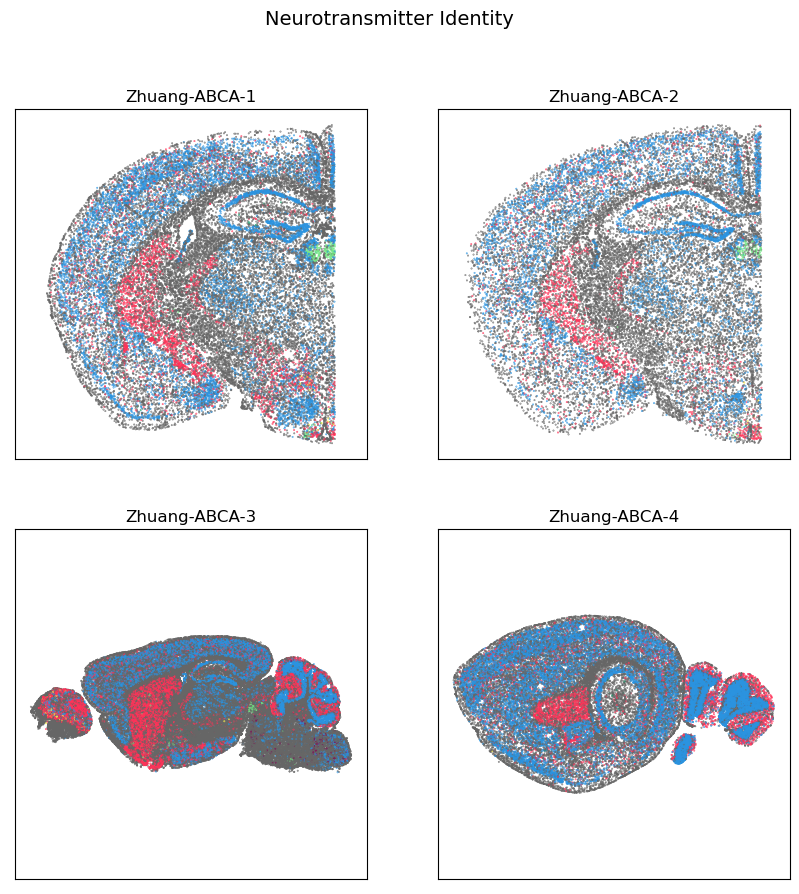

In [53]:
fig, ax = plot_sections( cell_extended, example_section, 'neurotransmitter_color' )
res = fig.suptitle('Neurotransmitter Identity', fontsize=14)

Zhuang-ABCA-1.079
Zhuang-ABCA-2.037
Zhuang-ABCA-3.010
Zhuang-ABCA-4.002


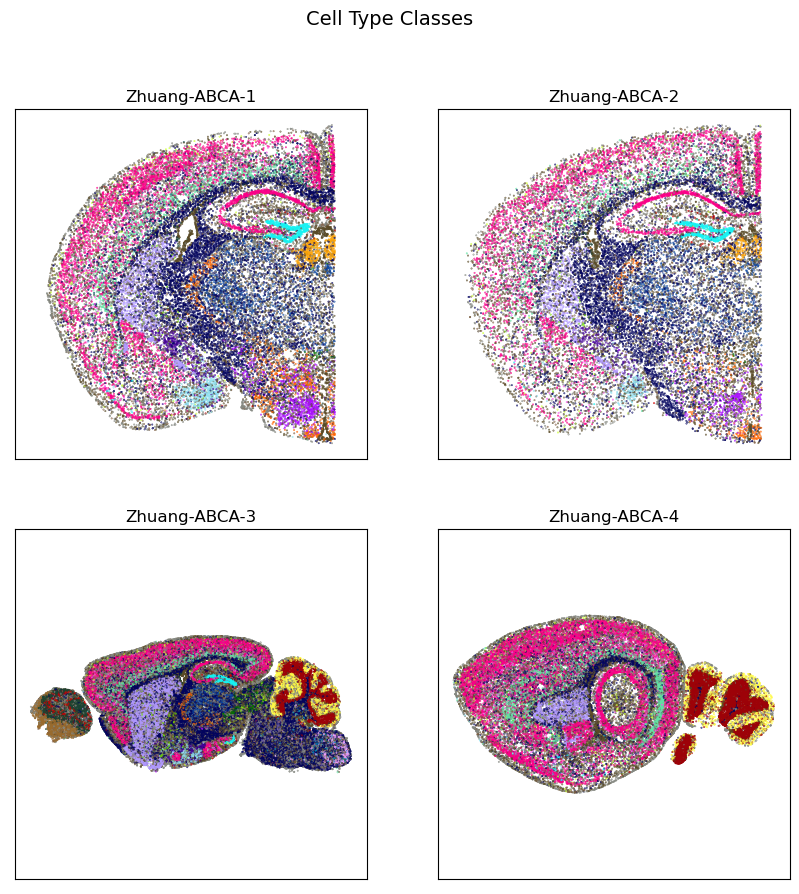

In [54]:
fig, ax = plot_sections( cell_extended, example_section, 'class_color' )
res = fig.suptitle('Cell Type Classes', fontsize=14)

Zhuang-ABCA-1.079
Zhuang-ABCA-2.037
Zhuang-ABCA-3.010
Zhuang-ABCA-4.002


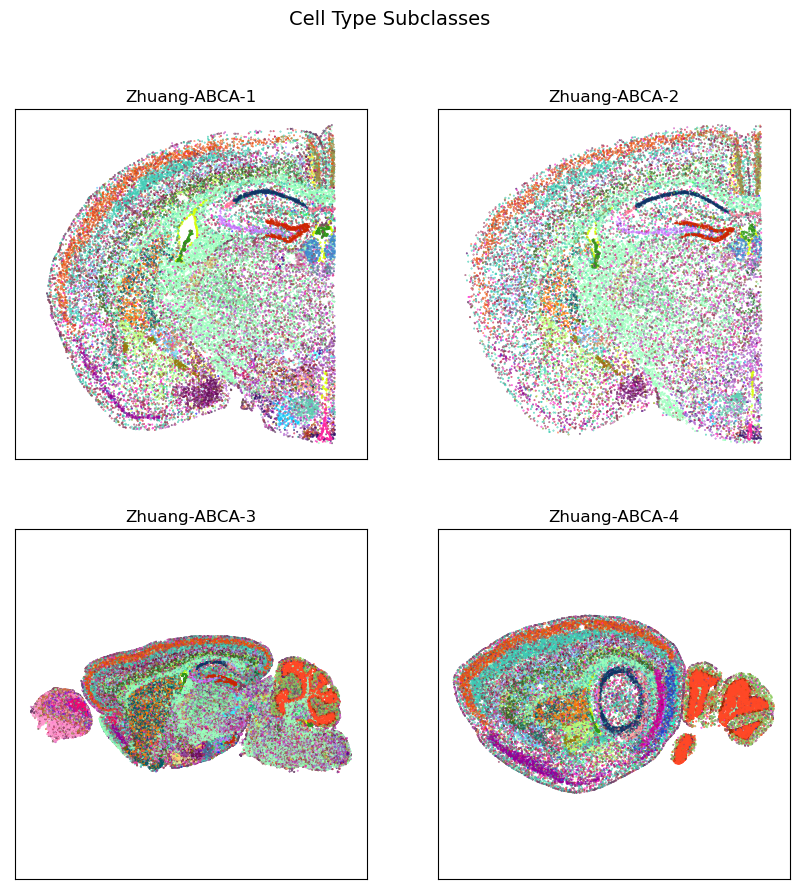

In [55]:
fig, ax = plot_sections( cell_extended, example_section, 'subclass_color' )
res = fig.suptitle('Cell Type Subclasses', fontsize=14)

## Example use case

In this section, we visualize the expression of nine canonical neurotransmitter transporter genes. To support these use cases, we will create a smaller submatrix (all cells and 9 genes) that read it into dataframe. *Note this operation takes around 2-5 minutes*.

In [56]:
htrgenes =  gene.gene_symbol[ gene.gene_symbol.str.contains("Htr")].values
htrgenes = np.sort(htrgenes)
pred = [x in htrgenes for x in gene.gene_symbol]
gene_filtered = gene[pred]
gene_filtered

gene_symbol                                         name  \
gene_identifier                                                               
ENSMUSG00000024798        Htr7   5-hydroxytryptamine (serotonin) receptor 7   
ENSMUSG00000050783       Htr1f  5-hydroxytryptamine (serotonin) receptor 1F   
ENSMUSG00000070687       Htr1d  5-hydroxytryptamine (serotonin) receptor 1D   
ENSMUSG00000026322        Htr4   5 hydroxytryptamine (serotonin) receptor 4   
ENSMUSG00000049511       Htr1b  5-hydroxytryptamine (serotonin) receptor 1B   
ENSMUSG00000034997       Htr2a  5-hydroxytryptamine (serotonin) receptor 2A   
ENSMUSG00000021721       Htr1a  5-hydroxytryptamine (serotonin) receptor 1A   
ENSMUSG00000041380       Htr2c  5-hydroxytryptamine (serotonin) receptor 2C   
ENSMUSG00000032269       Htr3a  5-hydroxytryptamine (serotonin) receptor 3A   

                   mapped_ncbi_identifier  
gene_identifier                            
ENSMUSG00000024798         NCBIGene:15566  
ENSMUSG00000050783         NCBIGene:15557  
ENSMUSG00000070687         NCBIGene:15552  
ENSMUSG00000026322         NCBIGene:15562  
ENSMUSG00000049511         NCBIGene:15551  
ENSMUSG00000034997         NCBIGene:15558  
ENSMUSG00000021721         NCBIGene:15550  
ENSMUSG00000041380         NCBIGene:15560  
ENSMUSG00000032269         NCBIGene:15561

In [57]:
cell_expression = {}
cell_expression_bool = {}

for d in datasets :
    
    expression_matrices[d]
    rpath = expression_matrices[d][d]['log2']['files']['h5ad']['relative_path']
    file = os.path.join( download_base, rpath)
    
    adata = anndata.read_h5ad(file,backed='r')
    
    start = time.process_time()
    gdata = adata[:,gene_filtered.index].to_df()
    gdata.columns = gene_filtered.gene_symbol
    cell_expression[d] = cell_extended[d].join( gdata )
    cell_expression_bool[d] = cell_extended[d].join( gdata.astype("bool") )
    
    print(d,"-","time taken: ", time.process_time() - start)
    
    adata.file.close()
    del adata


Zhuang-ABCA-1 - time taken:  35.49476305800002
Zhuang-ABCA-2 - time taken:  13.701745104999986
Zhuang-ABCA-3 - time taken:  15.357485637999986
Zhuang-ABCA-4 - time taken:  2.0067377039999883


### CCF registration and parcellation annotation

Each brain specimen has been registered to Allen CCFv3 atlas, resulting in an x, y, z coordinates and parcellation_index for each cell. 

In [58]:
ccf_coordinates = {}

for d in datasets :
    
    rpath = manifest['file_listing'][d+'-CCF']['metadata']['ccf_coordinates']['files']['csv']['relative_path']
    file = os.path.join( download_base, rpath)
    ccf_coordinates[d] = pd.read_csv(file)
    ccf_coordinates[d].set_index('cell_label',inplace=True)
    ccf_coordinates[d].rename(columns={'x':'x_ccf','y':'y_ccf','z':'z_ccf'},inplace=True)
    
    cell_expression[d] = cell_expression[d].join(ccf_coordinates[d],how='inner')
    cell_expression_bool[d] = cell_expression_bool[d].join(ccf_coordinates[d],how='inner')

Read in the pivot table from the "parcellation annotation tutorial" to associate each cell with terms at each anatomical parcellation level and the corresponding color.

In [59]:
metadata = manifest['file_listing']['Allen-CCF-2020']['metadata']
rpath = metadata['parcellation_to_parcellation_term_membership_acronym']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
parcellation_annotation = pd.read_csv(file)
parcellation_annotation.set_index('parcellation_index',inplace=True)
parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]

rpath = metadata['parcellation_to_parcellation_term_membership_color']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
parcellation_color = pd.read_csv(file)
parcellation_color.set_index('parcellation_index',inplace=True)
parcellation_color.columns = ['parcellation_%s'% x for x in  parcellation_color.columns]

In [60]:
for d in datasets :
    cell_expression[d] = cell_expression[d].join(parcellation_annotation,on='parcellation_index')
    cell_expression[d] = cell_expression[d].join(parcellation_color,on='parcellation_index')   
    cell_expression_bool[d] = cell_expression_bool[d].join(parcellation_annotation,on='parcellation_index')
    cell_expression_bool[d] = cell_expression_bool[d].join(parcellation_color,on='parcellation_index')   


Zhuang-ABCA-1.079
Zhuang-ABCA-2.037
Zhuang-ABCA-3.010
Zhuang-ABCA-4.002


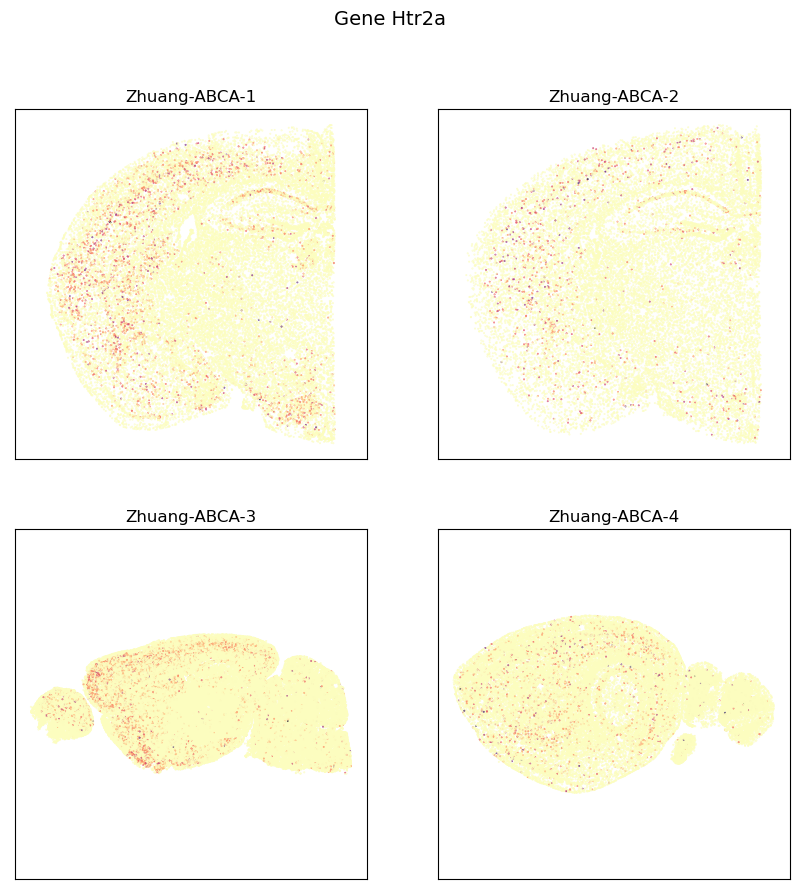

In [61]:
fig, ax = plot_sections( cell_expression, example_section, val='Htr2a', cmap=plt.cm.magma_r)
res = fig.suptitle('Gene Htr2a', fontsize=14)

In [62]:
def aggregate_by_metadata( df, gnames, value, sort=False ) :
    grouped = df.groupby(value)[gnames].mean()
    if sort :
        grouped = grouped.sort_values(by=gnames[0],ascending=False)
    return grouped

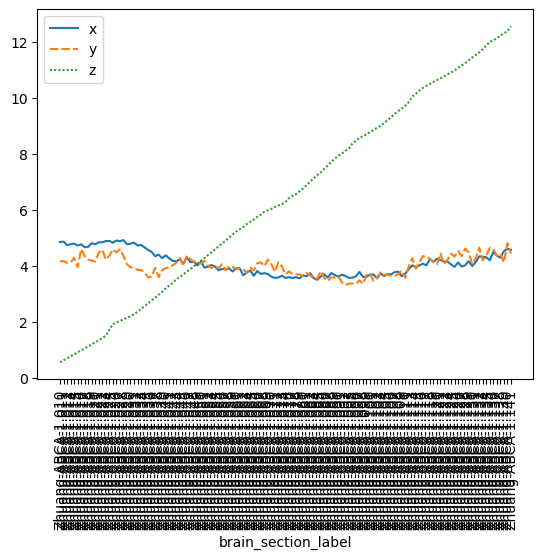

In [63]:
ax = sns.lineplot(cell_expression[datasets[0]].groupby('brain_section_label')[["x", "y", "z"]].mean())
ax.tick_params(axis='x', rotation=90)

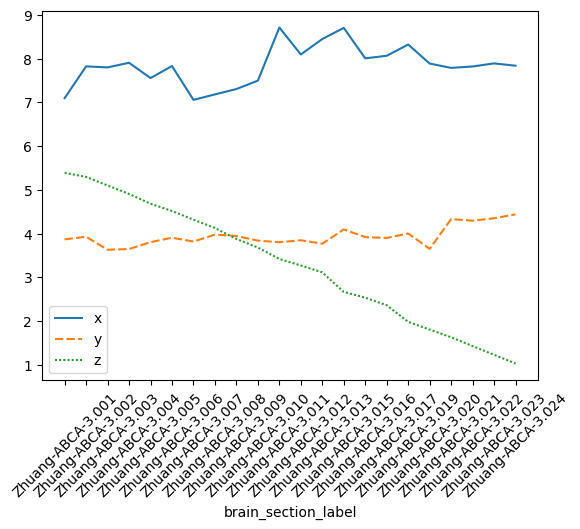

In [64]:
ax = sns.lineplot(cell_expression[datasets[2]].groupby('brain_section_label')[["x", "y", "z"]].mean())
ax.tick_params(axis='x', rotation=45)

In [ ]:
sns.heatmap(cell_expression[datasets[0]].groupby('brain_section_label')[htrgenes].mean())

In [ ]:
sns.heatmap(cell_expression[datasets[0]].groupby('z')[htrgenes].apply(percentage_non_zero), yticklabels=10)

In [ ]:
sns.heatmap(cell_expression[datasets[1]].groupby('brain_section_label')[htrgenes].mean())

In [ ]:
def percentage_non_zero(series):
    return (series != 0).sum() / len(series) * 100

result = cell_expression[datasets[0]].groupby("z")[gene].apply(percentage_non_zero)


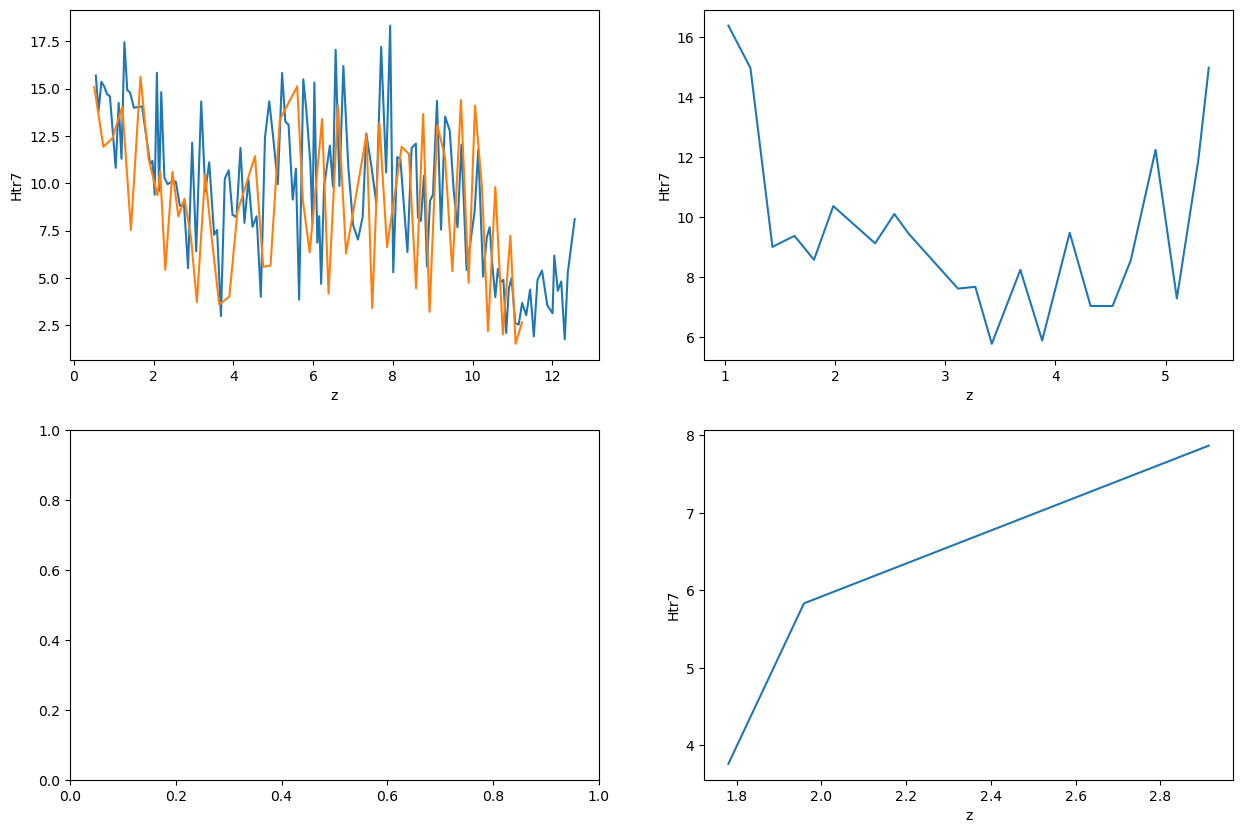

In [349]:
def percentage_non_zero(series):
    return (series != 0).sum() / len(series) * 100

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Compute and plot for each dataset
sns.lineplot(data=cell_expression[datasets[0]].groupby("z")[gene].apply(percentage_non_zero), ax=axs[0, 0])
sns.lineplot(data=cell_expression[datasets[1]].groupby("z")[gene].apply(percentage_non_zero), ax=axs[0, 0])
sns.lineplot(data=cell_expression[datasets[2]].groupby("z")[gene].apply(percentage_non_zero), ax=axs[0, 1])
sns.lineplot(data=cell_expression[datasets[3]].groupby("z")[gene].apply(percentage_non_zero), ax=axs[1, 1])
plt.show()

In [ ]:
sns.lineplot(data=pd.concat([cell_expression[datasets[0]], cell_expression[datasets[1]]]), x='brain_section_label', hue='feature_matrix_label', y=gene )

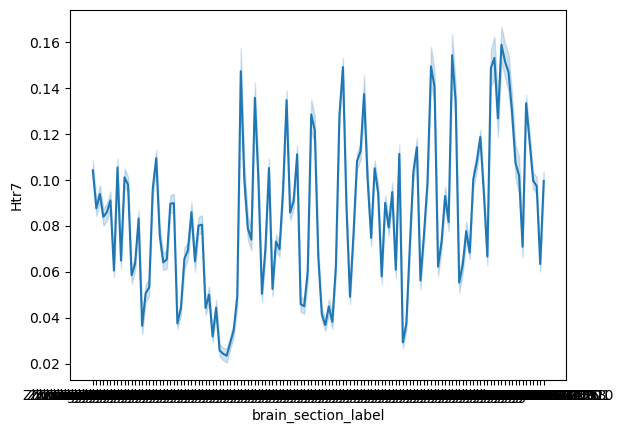

In [347]:
ax = sns.lineplot(data=cell_expression[datasets[0]], x='brain_section_label', y=gene )


<AxesSubplot:xlabel='z', ylabel='Htr7'>

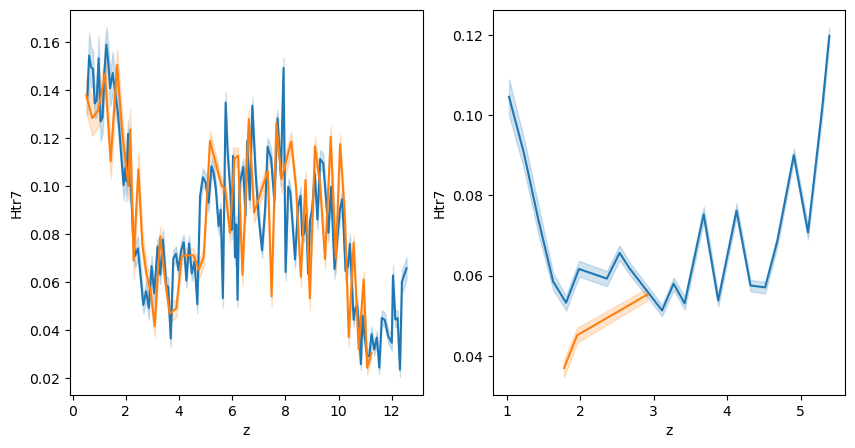

In [348]:

fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(data=cell_expression[datasets[0]], x='z', y=gene, ax=axs[0],markers=True, dashes=False)
sns.lineplot(cell_expression[datasets[1]], x='z', y=gene, ax=axs[0],markers=True, dashes=False)
sns.lineplot(cell_expression[datasets[2]], x='z', y=gene, ax=axs[1],markers=True, dashes=False)
sns.lineplot(cell_expression[datasets[3]], x='z', y=gene, ax=axs[1],markers=True, dashes=False)

In [ ]:
example_section = {'Zhuang-ABCA-1':'Zhuang-ABCA-1.079',
                   'Zhuang-ABCA-2':'Zhuang-ABCA-2.037',
                   'Zhuang-ABCA-3':'Zhuang-ABCA-3.010',
                   'Zhuang-ABCA-4':'Zhuang-ABCA-4.002'}

In [67]:
gene="Htr1a"

[]

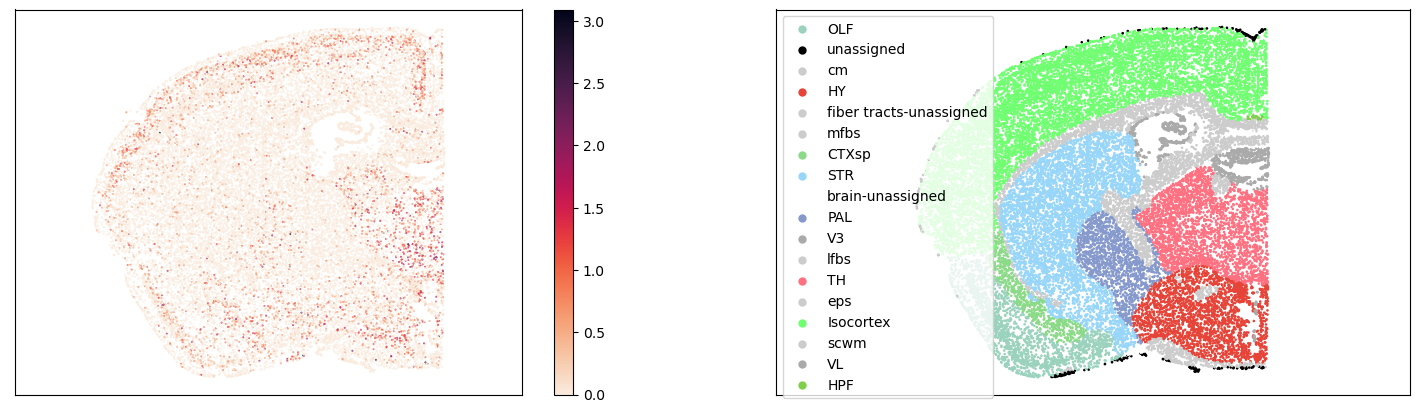

In [328]:

section = cell_expression['Zhuang-ABCA-1'][cell_expression['Zhuang-ABCA-1']['brain_section_label']==np.sort(cell_expression['Zhuang-ABCA-1']['brain_section_label'].unique())[60]]

    
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Create the scatter plot for the first axis and store the returned object
sc = axs[0].scatter(section['x'], section['y'], c=section[gene], marker=".", s=.5, 
                    cmap=sns.color_palette("rocket_r", as_cmap=True))
axs[0].set_ylim(11,0)
axs[0].set_xlim(0,11)
axs[0].axis('equal')
axs[0].set_xticks([])
axs[0].set_yticks([])
# Add a colorbar to the first scatter plot using the colormap from the scatter plot object
fig.colorbar(sc, ax=axs[0])

unique_parcellations = section.drop_duplicates(subset=['parcellation_division', 'parcellation_division_color'])

axs[1].scatter(section['x'], section['y'], c=section['parcellation_division_color'], marker=".", s=3)


# Create a legend for the second plot using dummy points
for division, color in zip(unique_parcellations['parcellation_division'], unique_parcellations['parcellation_division_color']):
    axs[1].scatter([], [], c=color, marker=".", s=100, label=division)

axs[1].legend(loc="best", fontsize="small")

axs[1].legend()
axs[1].set_ylim(11,0)
axs[1].set_xlim(0,11)
axs[1].axis('equal')
axs[1].set_xticks([])
axs[1].set_yticks([])
#plt.show()

In [343]:
# Create a sorted list of unique section names

dataset_changed = pn.widgets.Checkbox(name='Dataset Changed', value=False)


dataset_selector = pn.widgets.Select(name='Dataset Selector', options=datasets, value=datasets[0])

dataset = datasets[0]

section_names = sorted(cell_expression[dataset]['brain_section_label'].unique())

section_name_display = pn.pane.HTML()

# Create a slider for selecting brain sections based on the length of the section_names list
slider = pn.widgets.IntSlider(name='Brain Section Index', start=0, end=len(section_names) - 1, value=0)

gene_selector = pn.widgets.Select(name='Gene Selector', options=htrgenes.tolist(), value=htrgenes[0])


@pn.depends(dataset_selector.param.value, watch=True)
def on_dataset_change(selected_dataset):
    #print(f"Dataset changed to: {selected_dataset}") # Debugging print
    section_names = get_section_names(selected_dataset)
    slider.end = len(section_names) - 1
    #print(f"Slider end set to: {slider.end}") # Debugging print
    slider.param.set_param(value=0)
    #print(f"Slider value set to: {slider.value}") # Debugging print
    dataset_changed.value = True


def get_section_names(dataset):
    return sorted(cell_expression[dataset]['brain_section_label'].unique())

@pn.depends(dataset_selector.param.value, watch=True)
def update_slider_range(selected_dataset):
    section_names = get_section_names(selected_dataset)
    slider.end = len(section_names) - 1


@pn.depends(slider.param.value, dataset_selector.param.value, watch=True)
def update_section_name_display(section_index, dataset=dataset_selector.value):
    section_names = get_section_names(dataset)
    brain_section = section_names[section_index]
    section_name_display.object = f"<b>Brain Section:</b> {brain_section}"


@pn.depends(slider.param.value_throttled, gene_selector.param.value, dataset_selector.param.value)
def plot_expr_across_slices(section_index, gene, dataset):
    curve = hv.Curve(cell_expression[dataset].groupby('brain_section_label')[gene].mean(), label='Gene Expression').opts(xaxis=None, width=1000, height=250, active_tools=[], 
                                                                                                                        )
    vline = hv.VLine(section_index).opts(line_color='red', line_width=2)
    return curve * vline


@pn.depends(slider.param.value_throttled, gene_selector.param.value, dataset_selector.param.value)
def plot_section(section_index, gene, dataset):
    section_names = get_section_names(dataset)  
    # Check if the dataset has changed and reset the flag
    
    if dataset_changed.value:
        section_index = 0
        dataset_changed.value = False
        
    brain_section = section_names[section_index]
    section = cell_expression[dataset][cell_expression[dataset]['brain_section_label'] == brain_section]
    section = section[section['parcellation_division'] != "unassigned"]

    plot1 = hv.Points(data=section, kdims=['x', 'y' ], vdims=[gene,'parcellation_structure', 'parcellation_substructure']).opts(colorbar=True, cmap='rocket_r', size=2, color=gene)
    plot2 = hv.NdOverlay({division: hv.Points(section[section['parcellation_division'] == division], ['x', 'y'], ['parcellation_division_color','parcellation_structure', 'parcellation_substructure']).opts(color='parcellation_division_color', size=2) for division in section[section['parcellation_category'] == "grey"]['parcellation_division'].unique()}, kdims='parcellation_division').opts(legend_position='top_right', show_legend=True)

    common_opts = opts.Points(height=500, width=550, invert_yaxis=True, xaxis=None, yaxis=None, show_grid=False, active_tools=[], tools=["hover"])

    return (plot1 + plot2).opts(common_opts)

# Update inter to use the combined_plot function


pn.Column(pn.Row(gene_selector, dataset_selector, slider),section_name_display, plot_expr_across_slices, plot_section)

Column
    [0] Row
        [0] Select(name='Gene Selector', options=['Htr1a', 'Htr1b', ...], value='Htr1a')
        [1] Select(name='Dataset Selector', options=['Zhuang-ABCA-1', ...], value='Zhuang-ABCA-1')
        [2] IntSlider(end=128, name='Brain Section Index')
    [1] HTML(None)
    [2] ParamFunction(function, _pane=HoloViews, defer_load=False)
    [3] ParamFunction(function, _pane=HoloViews, defer_load=False)

In [286]:
import matplotlib.gridspec as gridspec


In [307]:
def plot_heatmap( df, fig_width = 8, fig_height = 4, cmap=plt.cm.magma_r, vmin=0, vmax=5) :

    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width,fig_height)

    res = ax.imshow(arr, cmap = cmap, aspect='auto', vmin=vmin, vmax=vmax)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels( xlabs )

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels( ylabs )

In [308]:
agg = aggregate_by_metadata( cell_expression[datasets[0]], htrgenes, 'brain_section_label', False )
agg = agg.loc[list(reversed(list(agg.index)))]
plot_heatmap(agg,5,11, vmax=3)

In [309]:
# Family breakdown
families = {
    'Htr1': ['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f'],
    'Htr2': ['Htr2a', 'Htr2b', 'Htr2c'],
    'Htr3': ['Htr3a', 'Htr3b'],
    'Htr4': ['Htr4'],
    'Htr5': ['Htr5a', 'Htr5b'],
    'Htr6': ['Htr6'],
    'Htr7': ['Htr7']
}

base_colors = sns.color_palette("husl", n_colors=len(families))
htr_cmap = {}

for idx, (family, members) in enumerate(families.items()):
    shades = sns.light_palette(base_colors[idx], n_colors=len(members) + 1)[1:]
    for receptor, shade in zip(members, shades):
        htr_cmap[receptor] = shade

# Convert RGB to HEX
htr_cmap_rgb = {k: plt_colors.rgb2hex(v) for k, v in htr_cmap.items()}



In [310]:
color_map = dict(zip(joined_bool["parcellation_structure"], joined_bool["parcellation_structure_color"].apply(plt_colors.to_rgba)))
color_map.update(dict(zip(joined_bool["parcellation_substructure"], joined_bool["parcellation_substructure_color"].apply(plt_colors.to_rgba))))
color_map.update(dict(zip(joined_bool["parcellation_division"], joined_bool["parcellation_division_color"].apply(plt_colors.to_rgba))))

In [311]:
order = [ 'FRP', 'MOp','SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-tr', 'SSp-ul', 'SSp-un',
       'SSs',  'GU', 'VISC', 'AUDd', 'AUDp', 'AUDpo',
       'AUDv','VISa', 'VISam', 'VISl', 'VISli', 'VISp',
       'VISpl', 'VISpm', 'VISpor', 'VISrl', 'VISal', 'ACAd','ACAv', 'PL', 'ILA',  'ORBl', 'ORBm',
       'ORBvl','AId', 'AIp', 'AIv', 'RSPv', 
       'RSPagl', 'RSPd', 'TEa','PERI', 'ECT'    ]

In [312]:
out = []
for gene in htrgenes:
    _ = (joined_bool[joined_bool['parcellation_division']=="Isocortex"].groupby('parcellation_structure')[gene].sum().div(joined_bool[joined_bool['parcellation_division']=="Isocortex"].groupby('parcellation_structure').size())*100).loc[order].rename("Percentage cells (%)").reset_index()
    _["Gene"] = gene
    out.append(_)

In [313]:
out = pd.concat(out, axis=0)

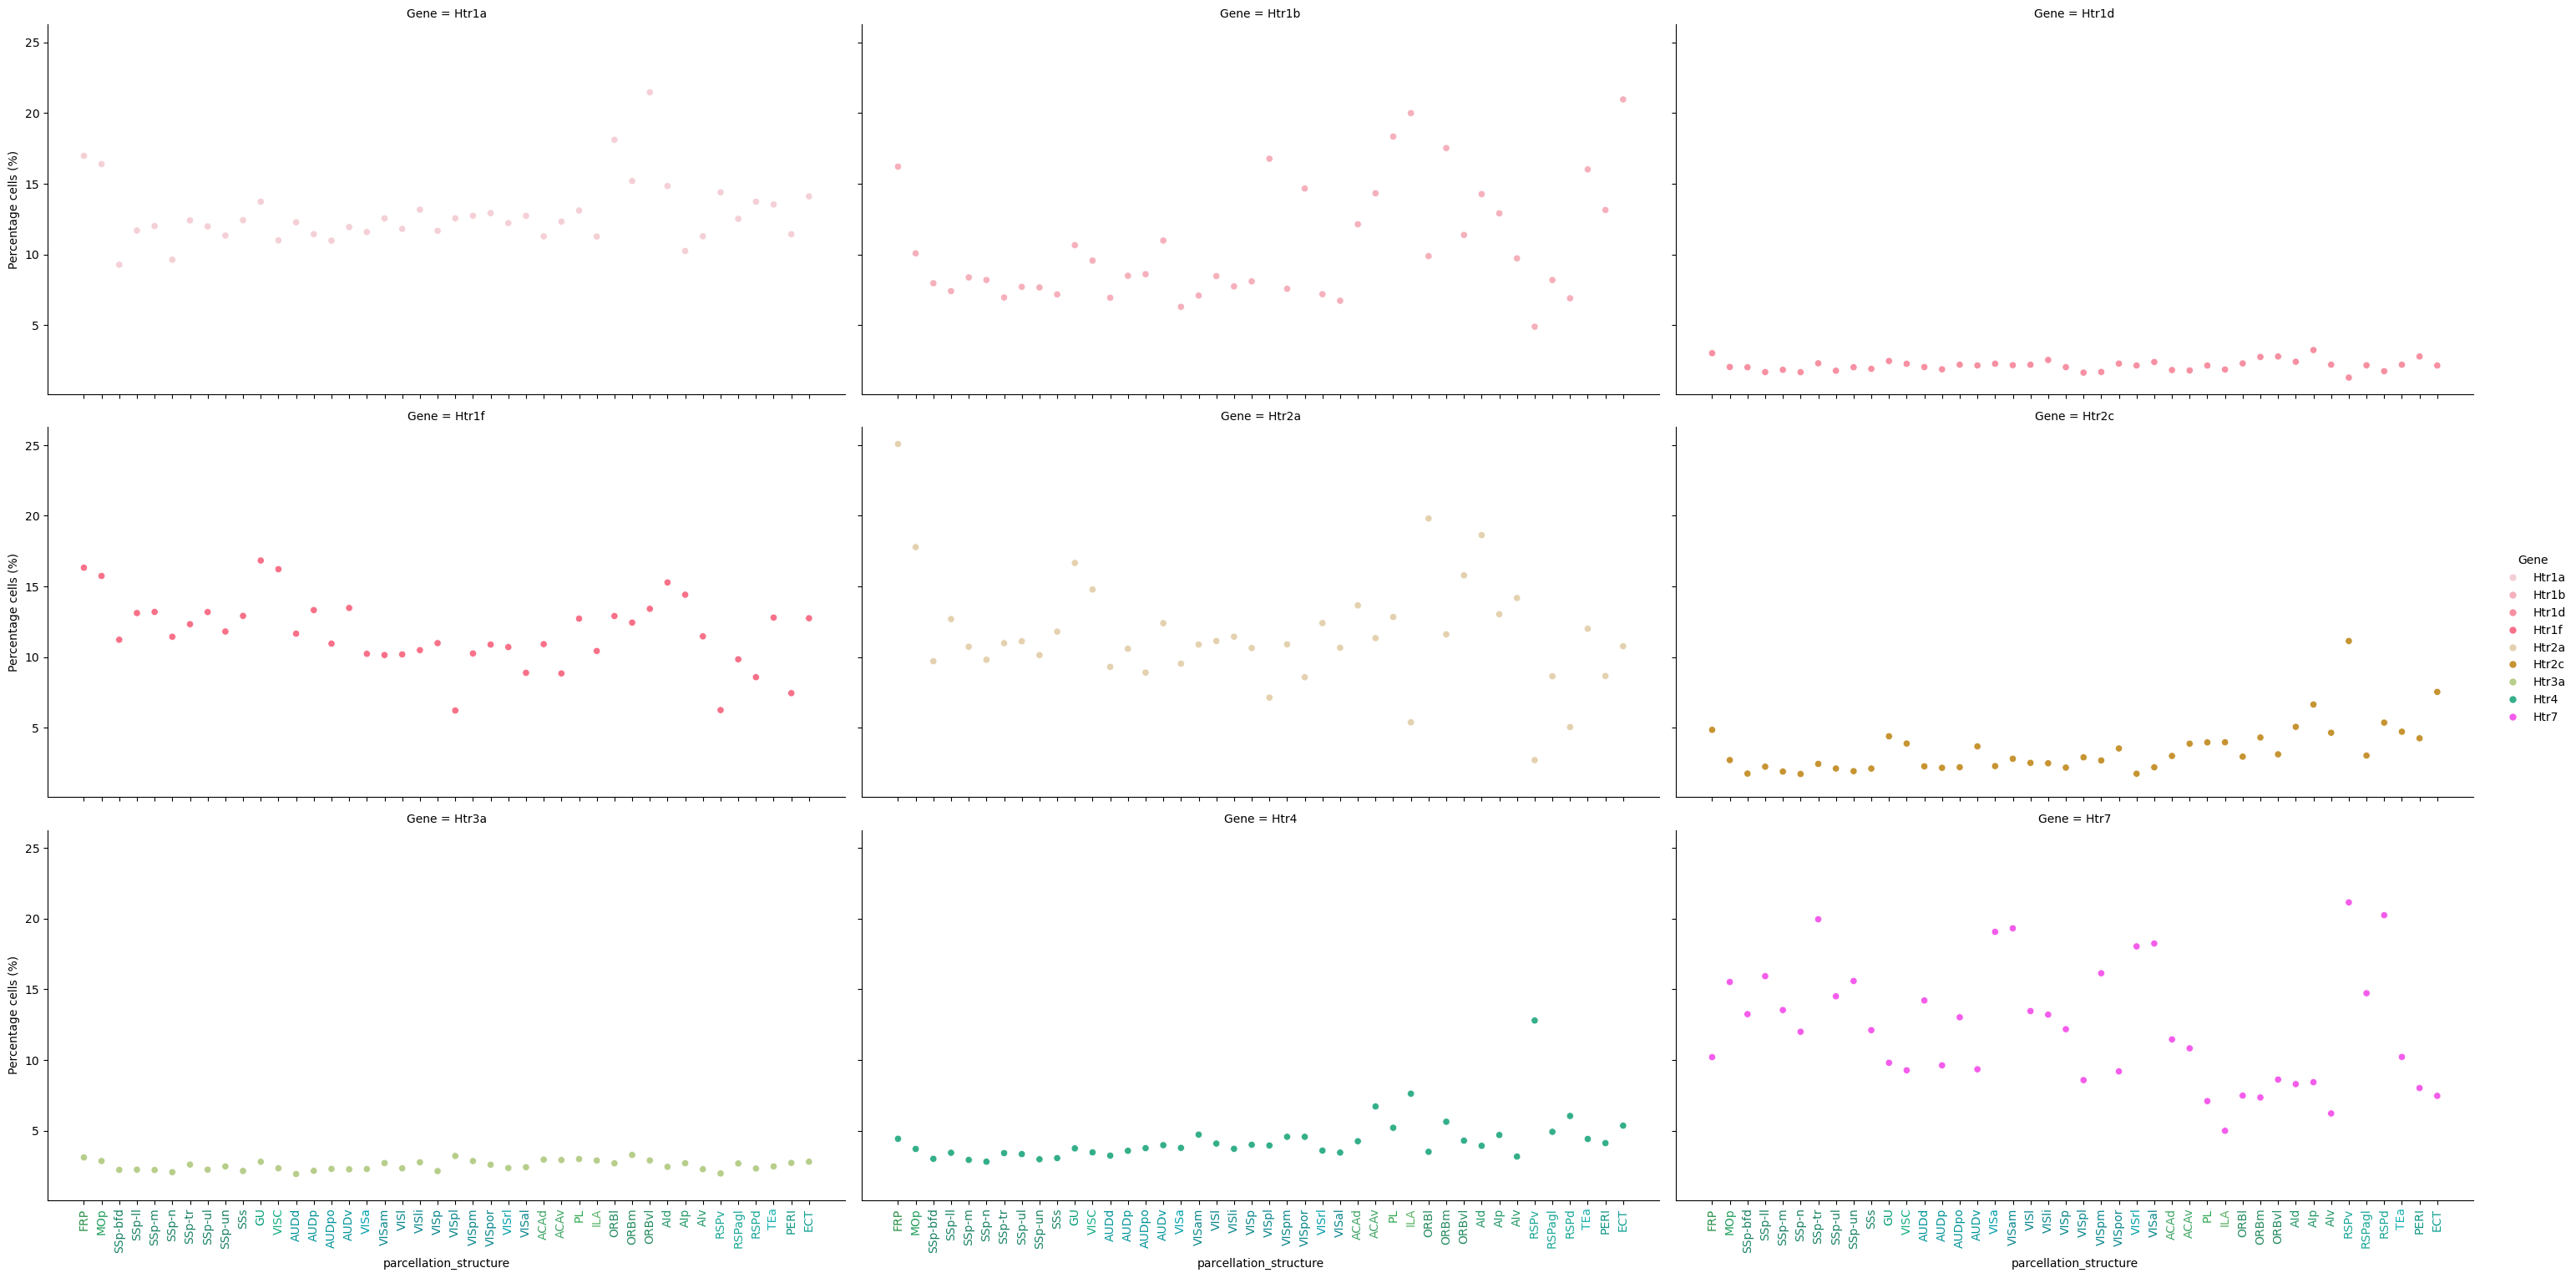

In [344]:
g = sns.relplot(kind="scatter", data=out, y="Percentage cells (%)", x ='parcellation_structure', col='Gene',col_wrap=3,hue="Gene", palette=htr_cmap, hue_order=htrgenes, aspect=2)

g.set_xticklabels(rotation=90)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_color(color_map[label.get_text()])
g

In [319]:
fig, ax = plt.subplots(figsize=(10,15))
sns.barplot(data=out, y="parcellation_structure", x="Percentage cells (%)", hue="Gene", palette=htr_cmap, ax=ax, hue_order=htrgenes)

plt.draw()
# Loop through each xtick label and set its color
for label in ax.get_yticklabels():
    label.set_color(color_map[label.get_text()])  # Set color for each label from color_map


In [ ]:
out = []
for gene in htrgenes:
    _ = (joined_bool[joined_bool['parcellation_division']=="Isocortex"].groupby(['parcellation_structure', 'parcellation_substructure'])[gene].sum().div(joined_bool[joined_bool['parcellation_division']=="Isocortex"].groupby(['parcellation_structure', 'parcellation_substructure']).size())*100).rename("Percentage cells expressing (%)").reset_index()
    _["Gene"] = gene
    out.append(_)

In [ ]:
out = pd.concat(out, axis=0)
# Assume df is your DataFrame
# Create a regular expression pattern to extract the layer information
pattern = r'(\d+[a-b]?/\d+[a-b]?|\d+[a-b]?)'

# Use str.extract to extract the layer information and create a new column called 'layer'
out['layer'] = out['parcellation_substructure'].str.extract(pattern)


In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=out.sort_values(["layer"], ascending=True),hue_order= htrgenes, y="layer", x="Percentage cells expressing (%)", hue="Gene", palette=htr_cmap, ax=ax)


In [ ]:
order = [ 'Isocortex','OLF','HPF','CTXsp',"STR", 'PAL','TH', 'HY', "MB", "P", "MY", "CB"]

joined_bool_sub = joined_bool[joined_bool['parcellation_division'].isin(order)]


In [ ]:
out = []
for gene in htrgenes:
    _ = (joined_bool_sub.groupby(['parcellation_division'])[gene].mean()*100).loc[order].rename("Percentage cells (%)").reset_index()
    _["Gene"] = gene
    out.append(_)
out = pd.concat(out, axis=0).reset_index(drop=True)


In [ ]:
ax = sns.stripplot(data=out, y="Percentage cells (%)", x ='parcellation_division', hue='Gene', palette=htr_cmap, jitter=.2)

plt.draw()
for label in ax.get_xticklabels():
    label.set_rotation(90)
    label.set_color(color_map[label.get_text()])

In [ ]:
g = sns.relplot(kind="scatter", data=out, y="Percentage cells (%)", x ='parcellation_division', col='Gene',col_wrap=3,hue="Gene", palette=htr_cmap)

g.set_xticklabels(rotation=90)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_color(color_map[label.get_text()])
